In [132]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [133]:
def list_classes_and_count(dataset_dir):
    classes = set()
    class_count = 0
    for root, dirs, files in os.walk(dataset_dir):
        for dir in dirs:
            classes.add(dir)
            class_count += 1
    return classes, class_count


# Directory paths for the two datasets
dataset_dir = "Plant Disease Recognition Dataset"

# List classes and count in each dataset
dataset_classes, dataset_classes = list_classes_and_count(dataset_dir + "/train")

# Display unique classes and the number of classes in each dataset
print("Classes in New Plant Diseases Dataset:")
print(dataset_classes)
print(f"Number of classes: {dataset_classes}")

Classes in New Plant Diseases Dataset:
3
Number of classes: 3


In [134]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image data generators for both datasets with augmentation
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    validation_split=0.2,
)

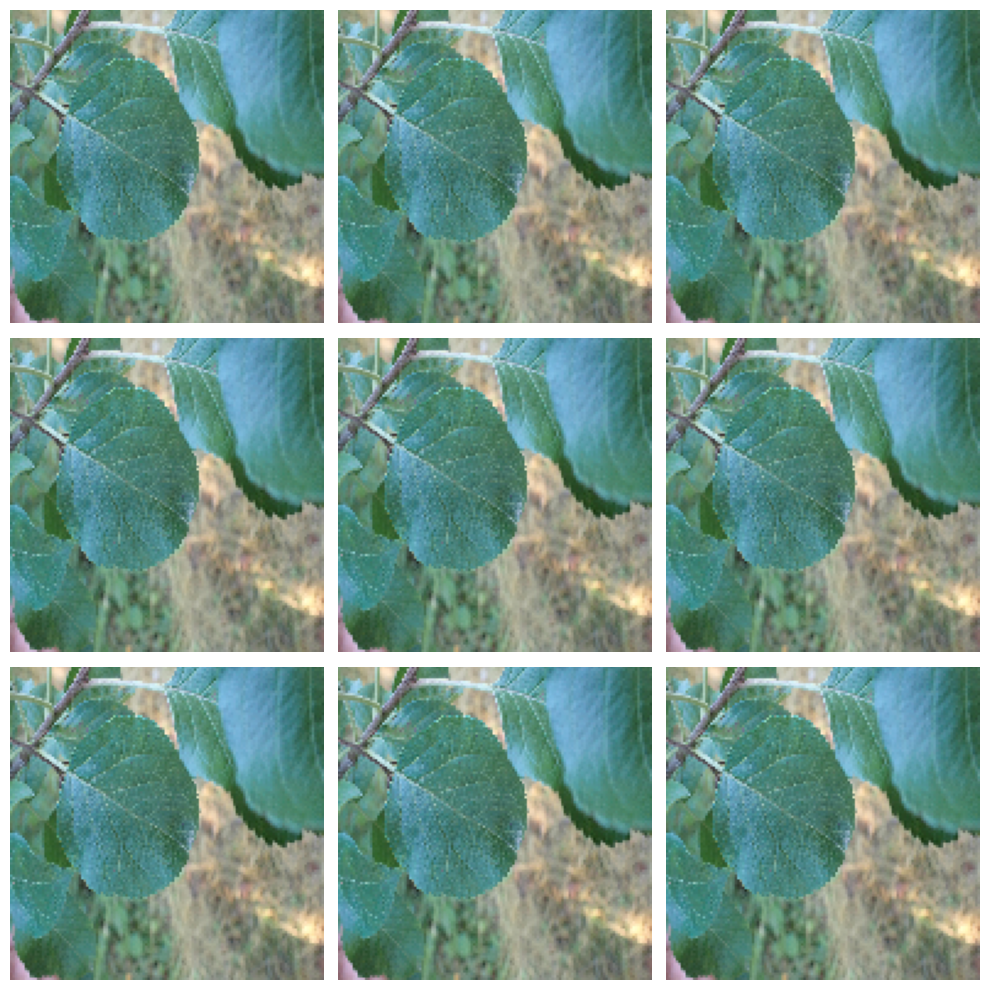

In [135]:
from tensorflow.keras.preprocessing import image

# Define an image path (replace this with an actual image path from your dataset)
image_path = "Plant Disease Recognition Dataset/Valid/Healthy/9bd4cc8c52e9d52a.jpg"

# Load and preprocess a single image for augmentation
img = image.load_img(image_path, target_size=(128, 128))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Generate augmented images
augmented_images = []
for _ in range(9):  # Generate 9 augmented images for visualization
    augmented_img = datagen.flow(x, batch_size=1)[0][0]
    augmented_images.append(augmented_img)

# Display the augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [136]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)


train_dataset = datagen.flow_from_directory(
    dataset_dir + "/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=1337,
    class_mode="categorical",
    subset="training",
)

valid_dataset = datagen.flow_from_directory(
    dataset_dir + "/valid",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=1337,
    class_mode="categorical",
    subset="validation",
)

Found 1059 images belonging to 3 classes.
Found 12 images belonging to 3 classes.


In [ ]:
# Check class distribution in the training dataset
train_class_count = train_dataset.classes
train_class_count_dict = {
    class_label: list(train_class_count).count(class_label)
    for class_label in range(len(train_dataset.class_indices))
}
print("Training Class Distribution:", train_class_count_dict)

# Check class distribution in the validation dataset
valid_class_count = valid_dataset.classes
valid_class_count_dict = {
    class_label: list(valid_class_count).count(class_label)
    for class_label in range(len(valid_dataset.class_indices))
}
print("Validation Class Distribution:", valid_class_count_dict)

# Plotting the class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(train_class_count_dict.keys(), train_class_count_dict.values())
axes[0].set_title("Training Class Distribution")
axes[0].set_xlabel("Class Label")
axes[0].set_ylabel("Count")

axes[1].bar(valid_class_count_dict.keys(), valid_class_count_dict.values())
axes[1].set_title("Validation Class Distribution")
axes[1].set_xlabel("Class Label")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

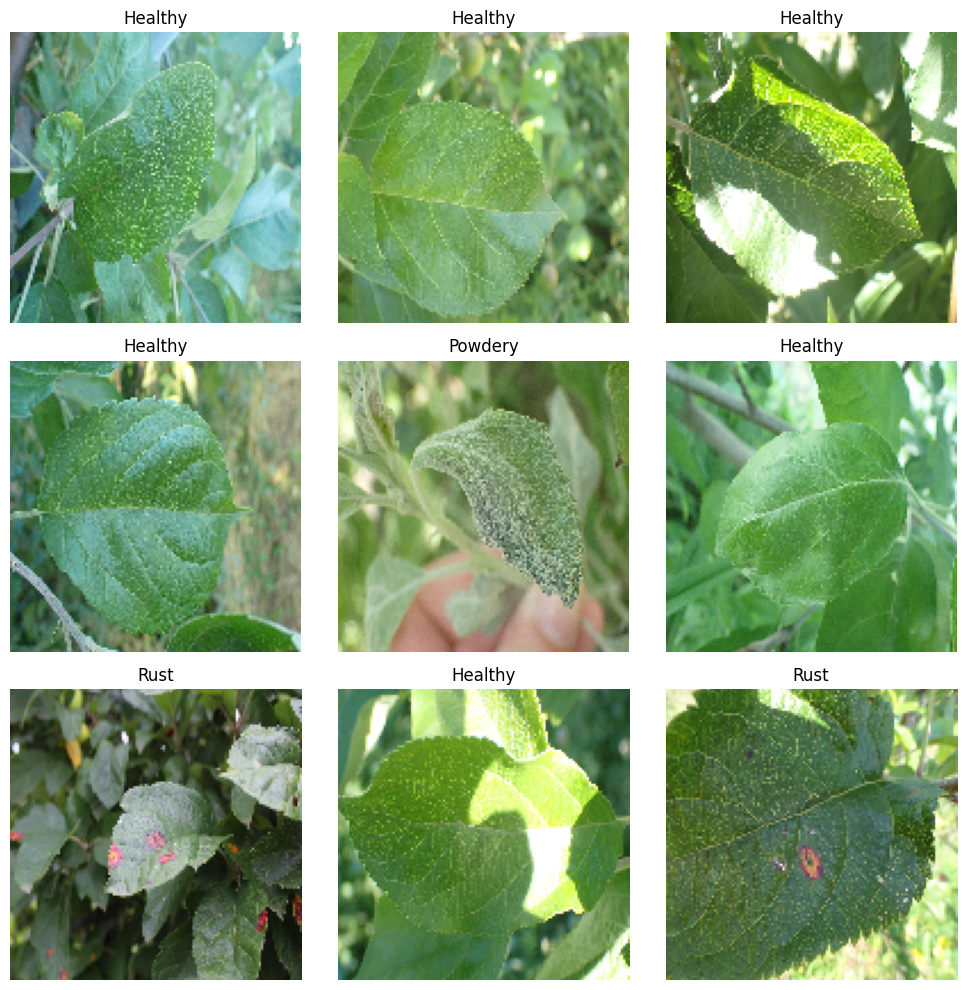

In [138]:
images, labels = next(train_dataset)

# Display images with class names as labels
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label_index = labels[i].argmax()  # Get index of the label
    plt.title(class_names[label_index])  # Use class name based on index
    plt.axis("off")

plt.tight_layout()
plt.show()

In [139]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    Dropout,
    BatchNormalization,
    Activation,
)
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load ResNet50 model without including the top fully-connected layers
IMG_SHAPE = IMG_SIZE + (3,)
base_model = ResNet50(input_shape=IMG_SHAPE, weights="imagenet", include_top=False)

for layer in base_model.layers:
    layer.trainable = True

In [ ]:
# # Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# # Fine-tune from this layer onwards
fine_tune_at = 100

# # Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [140]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_19[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [141]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Additional dense layers
x = Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.5)(x)

predictions = Dense(3, activation="softmax")(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

In [142]:
base_learning_rate = 0.005

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
    ],
)

In [143]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_19[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [144]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler

early_stopping = EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1
)


# Define a learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [145]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=valid_dataset,
    callbacks=[early_stopping, LearningRateScheduler(lr_scheduler)],
)

Epoch 1/100
34/34 [==============================] - 79s 2s/step - loss: 1.0875 - accuracy: 0.5127 - val_loss: 1.6001 - val_accuracy: 0.3333 - lr: 0.0050
Epoch 2/100
34/34 [==============================] - 71s 2s/step - loss: 0.8698 - accuracy: 0.6251 - val_loss: 1.2913 - val_accuracy: 0.3333 - lr: 0.0050
Epoch 3/100
34/34 [==============================] - 73s 2s/step - loss: 0.8287 - accuracy: 0.6251 - val_loss: 1.2468 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 4/100
34/34 [==============================] - 72s 2s/step - loss: 0.7863 - accuracy: 0.6610 - val_loss: 1.1783 - val_accuracy: 0.3333 - lr: 0.0050
Epoch 5/100
34/34 [==============================] - 73s 2s/step - loss: 0.7353 - accuracy: 0.6686 - val_loss: 1.5099 - val_accuracy: 0.3333 - lr: 0.0050
Epoch 6/100
34/34 [==============================] - 72s 2s/step - loss: 0.6791 - accuracy: 0.7129 - val_loss: 1.3815 - val_accuracy: 0.3333 - lr: 0.0050
Epoch 7/100
34/34 [==============================] - 72s 2s/step - loss: 0.6

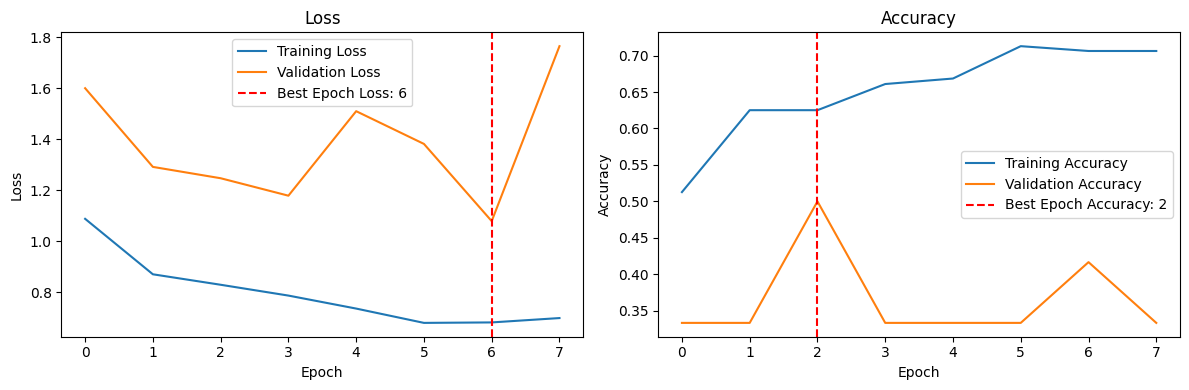

In [146]:
# Plot training history for loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Mark the best epoch for validation loss
best_epoch_loss = np.argmin(history.history["val_loss"])
plt.axvline(
    x=best_epoch_loss,
    color="r",
    linestyle="--",
    label=f"Best Epoch Loss: {best_epoch_loss}",
)
plt.legend()

# Plot training history for accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Mark the best epoch for validation accuracy
best_epoch_accuracy = np.argmax(history.history["val_accuracy"])
plt.axvline(
    x=best_epoch_accuracy,
    color="r",
    linestyle="--",
    label=f"Best Epoch Accuracy: {best_epoch_accuracy}",
)
plt.legend()

plt.tight_layout()
plt.show()

In [147]:
# Print the best epochs
print(f"Best Epoch for Validation Loss: {best_epoch_loss}")
print(f"Best Epoch for Validation Accuracy: {best_epoch_accuracy}")
print(f"Best Epoch for Validation Accuracy: {best_epoch_accuracy}")

Best Epoch for Validation Loss: 6
Best Epoch for Validation Accuracy: 2
Best Epoch for Validation Accuracy: 2


In [148]:
val_loss, val_accuracy, val_precision, val_recall, val_auc = model.evaluate(
    valid_dataset
)
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation AUC: {val_auc}")

1/1 [==============================] - 1s 1s/step - loss: 1.2468 - accuracy: 0.5000


ValueError: not enough values to unpack (expected 5, got 2)